In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.0272972299461 occ= 2
MO #3 (A1 #3), energy= -0.426131190105554 occ= 2
MO #4 (E1x #1), energy= -0.289938520612845 occ= 2
MO #5 (E1y #1), energy= -0.289938520612846 occ= 2
MO #6 (A1 #4), energy= -0.0349559135896411 occ= 0
MO #7 (A1 #5), energy= 0.664675049298748 occ= 0
MO #8 (E1x #2), energy= 1.13057093541209 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513674 occ= 0
MO #11 (A1 #7), energy= 1.57280313485608 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.29132770625063
Chemical Potential:  -0.1624472171012436
DFT trace:  7.12400971525713


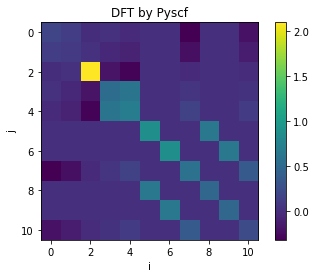

In [2]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
print('Chemical Potential: ', str(mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
#mmwrite('dft_overlap.mtx', sparse.coo_matrix(ovlp))

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())

plt.imshow(dm.real)
plt.title("DFT by Pyscf")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

NTPoly Trace:  4.015391362234546


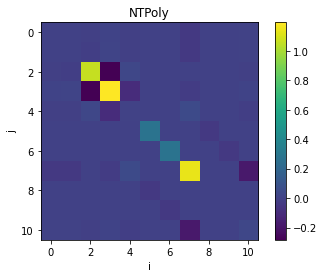

In [3]:
ntpoly_rho = nt.NTPoly_cp(h1e, ovlp, int(dm.trace()))
print("NTPoly Trace: ", ntpoly_rho.trace())

plt.imshow(ntpoly_rho.real)
plt.title("NTPoly")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

GCP steps:  14
Palser GCP trace:  (4.999999999999999+0j)
CP steps:  0
Palser CP trace:  (7.124009715257131+0j)


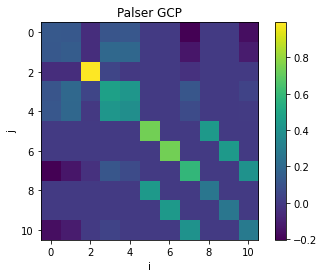

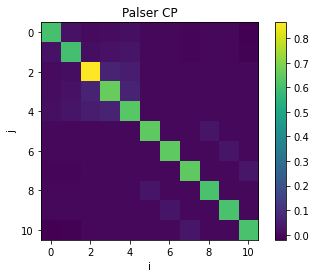

In [4]:
# Palser solver
better_mu = -10
palser_gcp_rho = pals.gcp(better_mu, h1e, 1000)
print("Palser GCP trace: ", palser_gcp_rho.trace())
palser_cp_rho = pals.cp(dm.trace(), h1e, 1000)
print("Palser CP trace: ", palser_cp_rho.trace())

plt.figure(1)
plt.imshow(palser_gcp_rho.real)
plt.title("Palser GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(palser_cp_rho.real)
plt.title("Palser CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

DMM GCP trace:  4.553880323553057
DMM CP trace:  7.000000000000007


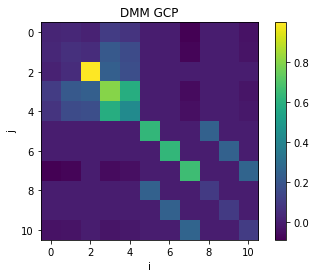

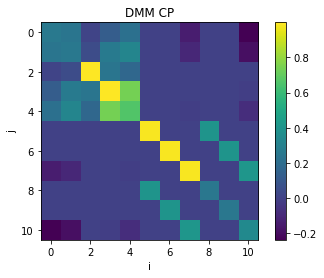

In [5]:
# DMM Solvers
dbeta = 0.003
num_electrons = 7

inv_ovlp = np.linalg.inv(ovlp)
init_rho = num_electrons/ovlp.trace() * ovlp
identity = np.identity(init_rho.shape[0])

dmm_gcp = gcp.rk4(gcp.rhs, init_rho.copy(), dbeta, h1e, inv_ovlp, identity, better_mu, 1000)
print("DMM GCP trace: ", dmm_gcp.trace())
dmm_cp = cp.rk4(cp.rhs, init_rho.copy(), dbeta, h1e, inv_ovlp, identity, 1000)
print("DMM CP trace: ", dmm_cp.trace())

plt.figure(1)
plt.imshow(dmm_gcp.real)
plt.title("DMM GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(dmm_cp.real)
plt.title("DMM CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

Iterations converged!


Text(0, 0.5, '||p_n+1 - p_n||')

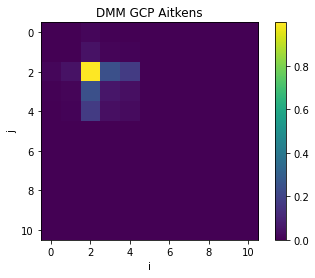

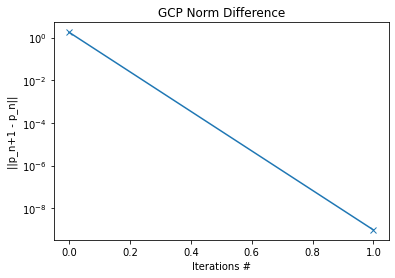

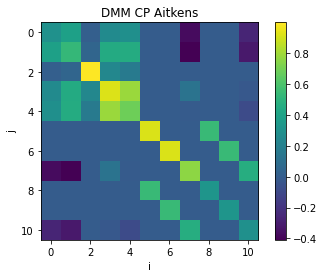

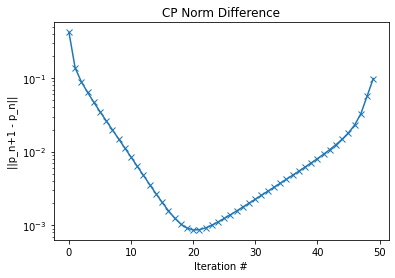

In [6]:
# Perform Aitkens convergence method on DMM methods
func_args = {'h1e': h1e, 'mf': mf, 'mu': better_mu, 'inv_ovlp': inv_ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
gcp_aitkens_rho, norm_diff = gcp.aitkens(dmm_gcp, 50, gcp.single_step, func_args)

plt.figure(1)
plt.imshow(gcp_aitkens_rho)
plt.title("DMM GCP Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, 'x-')
plt.title("GCP Norm Difference")
plt.xlabel("Iterations #")
plt.ylabel("||p_n+1 - p_n||")

func_args = {'h1e': h1e, 'mf': mf, 'inv_ovlp': inv_ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
cp_aitkens_rho, norm_diff = gcp.aitkens(dmm_cp, 50, cp.single_step, func_args)

plt.figure(3)
plt.imshow(cp_aitkens_rho)
plt.title("DMM CP Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, 'x-')
plt.title("CP Norm Difference")
plt.xlabel("Iteration #")
plt.ylabel("||p_n+1 - p_n||")

funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1.6267361403620778e-06
funm result may be inaccurate, approximate err = 6.266409148441362e-06
funm result may be inaccurate, approximate err = 0.0010506509600691973
funm result may be inaccurate, approximate err = 0.002741631696263651
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.0028303047811291423
funm result may be inaccurate, approximate err = 0.9434436597350142
funm result may be inaccurate, approximate err = 0.4701846169443191
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.35940708815894995
funm result may be inaccurate, approximate err = 0.37614765686020774
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.53735379414456

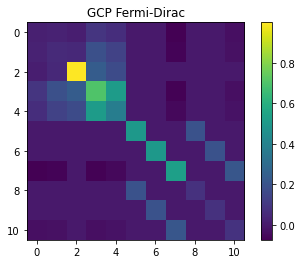

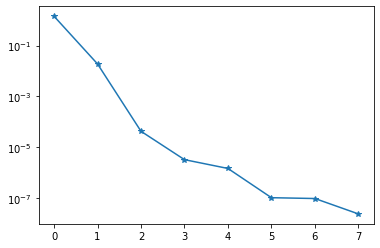

In [7]:
func_args = {'h1e': h1e, 'mf': mf, 'mu': better_mu, 'inv_ovlp': inv_ovlp, 'beta': 1000*dbeta, 'ovlp': ovlp}
gcp_exact = ovlp @  linalg.funm(inv_ovlp @ h1e, lambda _: 1/(1+np.exp(func_args['beta']*(_ - better_mu))))

gcp_aitkens_rho, norm_diff = gcp.aitkens(gcp_exact, 50, gcp.exact_single_step, func_args)
plt.imshow(gcp_exact.real)
plt.title("GCP Fermi-Dirac")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')

Text(0.5, 0, 'Iteration #')

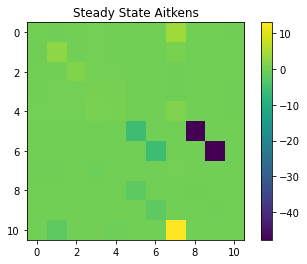

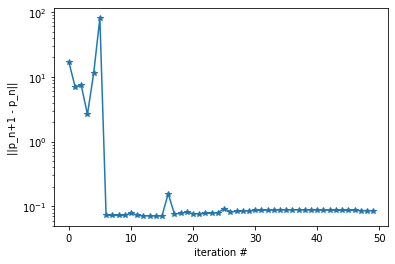

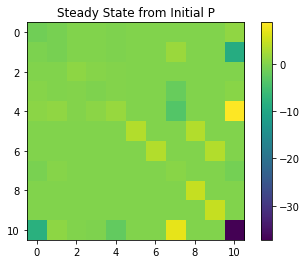

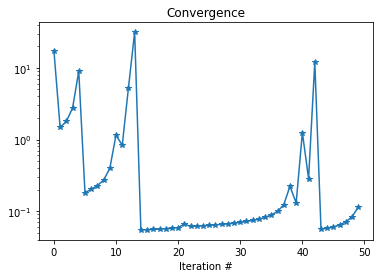

In [11]:
steady_gcp_aitkens, norm_diff = gcp.aitkens(dmm_gcp.copy(), 50, gcp.steady_single_step, func_args)
plt.figure(1)
plt.imshow(steady_gcp_aitkens.real)
plt.title("Steady State Aitkens")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.xlabel("iteration #")
plt.ylabel("||p_n+1 - p_n||")

steady_gcp_aitkens2, norm_diff = gcp.aitkens(init_rho.copy(), 50, gcp.steady_single_step, func_args)
plt.figure(3)
plt.imshow(steady_gcp_aitkens2.real)
plt.title("Steady State from Initial P")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, '*-')
plt.title("Convergence")
plt.xlabel("Iteration #")